# IN-STK5000/9000 - Medical Project

## Part 1 - Historical Data

Discovering structure in the data. It is uncertain if the symptoms present are all due to
the same disease, or if they are different conditions with similar symptoms. (a) looking at the
data (including symptoms), estimate whether a single-cause model is more likely than a multiplecause model. You can use anything, ranging from histograms or simple clustering algorithms
to a hierarchical Bayesian model.   

***  



### From data readme  

This is historical data in three tables.

X: observations about each patient
A: treatment
Y: outcome of treatment

The data is organised in the following files:

historical.dat: all the tables in one file (matlab format)
historical_X.dat: the X data
historical_A.dat: the A data
historical_Y.dat: the Y data

Modelling the X data can be done through both unsupervised and supervised models. As some of the genome features might be irrelevant, it is probably a good idea to try and filter them out somehow. In later parts of the project, you will be able to perform experiments to narrow done the important genes. For the latter approach, you can combine the last two columns into a classification label, which should give you a cross-validation score of between 60-70%.



### Assumptions  
every person has some disease

say something about confounder variable

Look at clusters, see how they separate features, symptoms  

Biplot on symptoms, look at eigenvalues for components  

https://stackoverflow.com/questions/39216897/plot-pca-loadings-and-loading-in-biplot-in-sklearn-like-rs-autoplot

np.cumsum(pca_model.explained_variance_ratio_)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA, KernelPCA
# from pca import pca as PCA

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score   
import seaborn as sns

import matplotlib.cm as cm

In [2]:
# for reproducibility
SEED = 1337
np.random.seed(SEED)

Let's take a look at the dataset

In [3]:
feature_path = "../../data/medical/historical_X.dat"

X = pd.read_csv(feature_path, delimiter=" ", names=["sex", "smoker"] \
                                           + [f"gen_{i}" for i in range(1, 127)] \
                                           + ["symptom_1","symptom_2"])
X

,sex,smoker,gen_1,gen_2,gen_3,gen_4,gen_5,gen_6,gen_7,gen_8,...,gen_119,gen_120,gen_121,gen_122,gen_123,gen_124,gen_125,gen_126,symptom_1,symptom_2
0,0,0,0,0,1,1,0,0,1,1,...,0,1,1,0,1,1,0,0,1,0
1,0,1,0,1,0,1,0,0,1,0,...,0,1,0,1,0,1,0,1,0,0
2,0,0,1,1,0,0,1,1,0,0,...,0,0,0,1,0,0,1,1,0,0
3,1,1,1,0,0,0,1,1,0,0,...,1,0,1,1,0,0,1,1,0,0
4,0,1,0,1,0,1,1,1,1,1,...,0,0,0,1,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,1,0,1,1,0,1,0,...,0,1,0,0,1,0,0,1,1,0
9996,1,0,1,1,1,0,1,1,0,0,...,1,0,1,1,0,0,1,0,0,0
9997,0,0,1,0,1,0,0,1,0,1,...,1,1,1,0,1,1,1,0,0,0
9998,1,1,0,1,0,0,1,0,0,0,...,0,0,0,0,1,1,0,1,0,0


The task is to investigate whether there is a single disease or multiple diseases, and our best cues lies in the symptoms and their causes. For instance, sex and genetic data is assigned at birth, so we know that if there is a prominent correlation between those attributes and the symptoms, we know, assuming that symptoms are not before genes and sex, that these attributes cause the symptoms. However, we cannot assume such on sex. 

Built into pandas, we can use the corr method to find the correlation matrix for each feature.

In [26]:
X_corr = X.corr()
X_corr

,sex,smoker,gen_1,gen_2,gen_3,gen_4,gen_5,gen_6,gen_7,gen_8,...,gen_119,gen_120,gen_121,gen_122,gen_123,gen_124,gen_125,gen_126,symptom_1,symptom_2
sex,1.000000,0.109603,0.007766,0.014346,-0.009029,0.005035,-0.010778,0.002589,-0.004750,-0.003941,...,0.012595,0.001446,0.002208,-0.000617,-0.023393,-0.014812,-0.001430,-0.014648,0.014270,0.012175
smoker,0.109603,1.000000,0.050425,-0.007127,0.030977,-0.021665,0.025645,0.036442,-0.019263,0.006718,...,0.021938,-0.025307,-0.007724,0.006012,0.014049,0.010707,0.020846,-0.012551,-0.023566,0.145667
gen_1,0.007766,0.050425,1.000000,-0.046432,0.386332,-0.395919,0.084694,0.566400,-0.374882,-0.116801,...,0.330004,-0.371892,0.010433,0.219953,0.135637,-0.039847,0.476740,-0.139736,-0.226389,0.113284
gen_2,0.014346,-0.007127,-0.046432,1.000000,-0.141214,0.105647,0.056152,-0.145896,-0.230952,-0.275728,...,-0.047439,-0.293198,-0.453831,-0.189144,-0.204592,0.287582,-0.058403,0.213693,0.448432,0.077794
gen_3,-0.009029,0.030977,0.386332,-0.141214,1.000000,-0.165907,0.007472,0.273980,-0.184872,0.250451,...,0.492008,-0.033860,0.224838,-0.240869,0.198433,0.124570,0.201123,-0.236210,-0.138678,0.236765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gen_124,-0.014812,0.010707,-0.039847,0.287582,0.124570,0.057048,-0.068374,-0.297818,-0.024739,-0.029531,...,-0.177008,-0.180164,-0.171791,-0.366230,0.035009,1.000000,-0.361859,0.030987,0.136688,0.062525
gen_125,-0.001430,0.020846,0.476740,-0.058403,0.201123,-0.478340,0.178688,0.473991,-0.349298,-0.249663,...,0.410805,-0.198281,0.036030,0.257561,0.180434,-0.361859,1.000000,-0.124496,-0.268632,0.071965
gen_126,-0.014648,-0.012551,-0.139736,0.213693,-0.236210,0.215471,0.048148,-0.087031,0.033066,-0.021576,...,-0.108583,-0.007114,-0.140690,-0.033081,-0.090537,0.030987,-0.124496,1.000000,0.191198,-0.052944
symptom_1,0.014270,-0.023566,-0.226389,0.448432,-0.138678,0.558176,0.115776,-0.108642,0.044841,0.129694,...,-0.081114,0.013884,-0.232290,-0.174283,-0.125147,0.136688,-0.268632,0.191198,1.000000,-0.017210


Let's look at the most correlated features with respect to the symptoms

<AxesSubplot:>

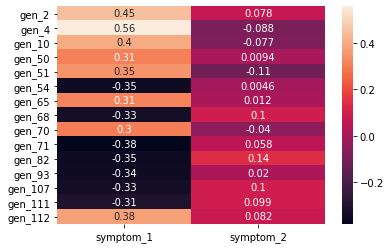

In [39]:
cond = (X_corr["symptom_1"] > 0.3)  | (X_corr["symptom_1"] < -0.3) | (X_corr["symptom_2"] > 0.3) | (X_corr["symptom_2"] < -0.3)
most_significant = X_corr.loc[cond][["symptom_1", "symptom_2"]][:-2]
sns.heatmap(most_significant, annot=True)

The first symptom seems to be caused by genetical factors more than anything, both positively and negatively. The second symptom did not give us any highly correlated features, which might indicate

In [43]:
columns = list(X.columns)
X.corr()[["symptom_1", "symptom_2"]][:2]

,symptom_1,symptom_2
sex,0.014270,0.012175
smoker,-0.023566,0.145667


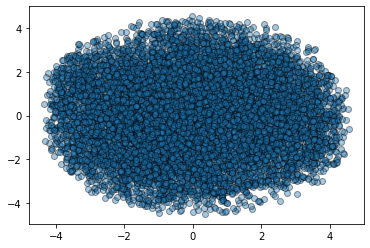

In [52]:
reductor = PCA(n_components=2)
x1, x2 = xT = reductor.fit_transform(X).T
plt.scatter(x1, x2, edgecolor="k", alpha=0.4)

array([[ 0.00075843, -0.00890035, -0.16393006,  0.02472733, -0.06333461,
         0.1541863 ,  0.03989921, -0.08182414,  0.07381733,  0.09200361,
        -0.16834371,  0.16926509, -0.07091371,  0.00168031, -0.12667818,
        -0.11581766, -0.00906537, -0.1489484 ,  0.09709071,  0.02984483,
         0.09050446,  0.09111585, -0.08787622, -0.0498472 ,  0.01921897,
        -0.00451866,  0.14040417,  0.07709331, -0.15880938,  0.11754471,
        -0.10156179,  0.01629345, -0.03445318, -0.06205496, -0.011764  ,
        -0.06384064, -0.13167011,  0.00117253, -0.00301209, -0.08271387,
        -0.00780131, -0.01846795,  0.0233848 , -0.1193256 ,  0.12923635,
         0.1447545 , -0.12374441, -0.10625689, -0.00175028, -0.0264625 ,
         0.04155181,  0.11007786,  0.18677304, -0.04516313,  0.02380553,
        -0.13209127, -0.00812019, -0.05421996,  0.02766769, -0.00515389,
         0.10250762,  0.04942376,  0.08490886, -0.05015803,  0.00570803,
         0.11789394,  0.0960391 , -0.07627002,  0.0

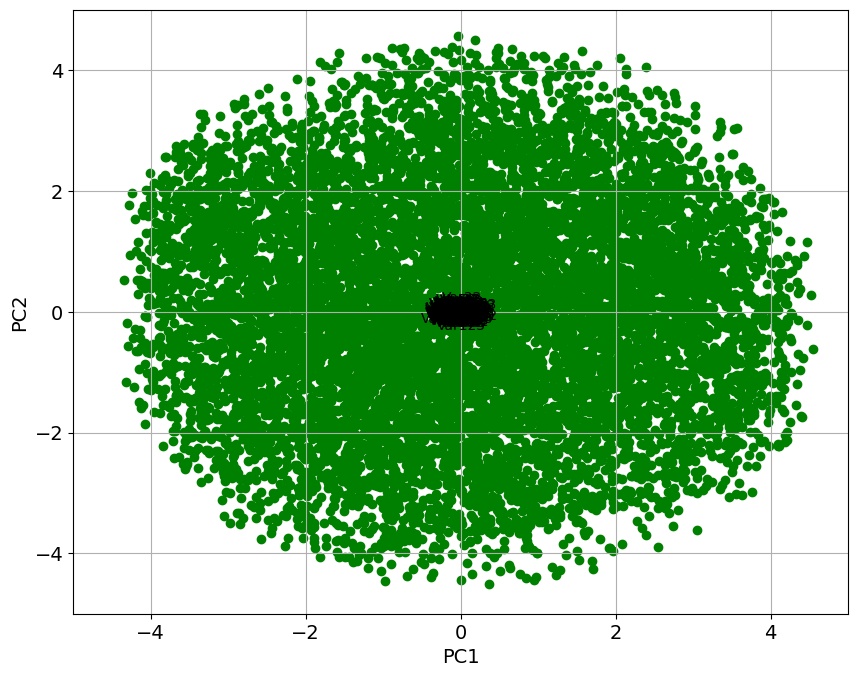

In [56]:
# credit to https://towardsdatascience.com/pca-clearly-explained-how-when-why-to-use-it-and-feature-importance-a-guide-in-python-7c274582c37e
def biplot(score, coeff , y):
    '''
    Author: Serafeim Loukas, serafeim.loukas@epfl.ch
    Inputs:
       score: the projected data
       coeff: the eigenvectors (PCs)
       y: the class labels
   '''
    xs = score[:,0] # projection on PC1
    ys = score[:,1] # projection on PC2
    n = coeff.shape[0] # number of variables
    plt.figure(figsize=(10,8), dpi=100)
    classes = np.unique(y)
    colors = ['g','r','y']
    markers=['o','^','x']
    for s,l in enumerate(classes):
        plt.scatter(xs[y==l],ys[y==l], c = colors[s], marker=markers[s]) # color based on group
    for i in range(n):
        #plot as arrows the variable scores (each variable has a score for PC1 and one for PC2)
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'k', alpha = 0.9,linestyle = '-',linewidth = 1.5, overhang=0.2)
        plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'k', ha = 'center', va = 'center',fontsize=10)

    plt.xlabel("PC{}".format(1), size=14)
    plt.ylabel("PC{}".format(2), size=14)
    limx= int(xs.max()) + 1
    limy= int(ys.max()) + 1
    plt.xlim([-limx,limx])
    plt.ylim([-limy,limy])
    plt.grid()
    plt.tick_params(axis='both', which='both', labelsize=14)
    
biplot(xT.T, np.transpose(reductor.components_[0:2, :]), np.zeros(len(x1)))
reductor.components_

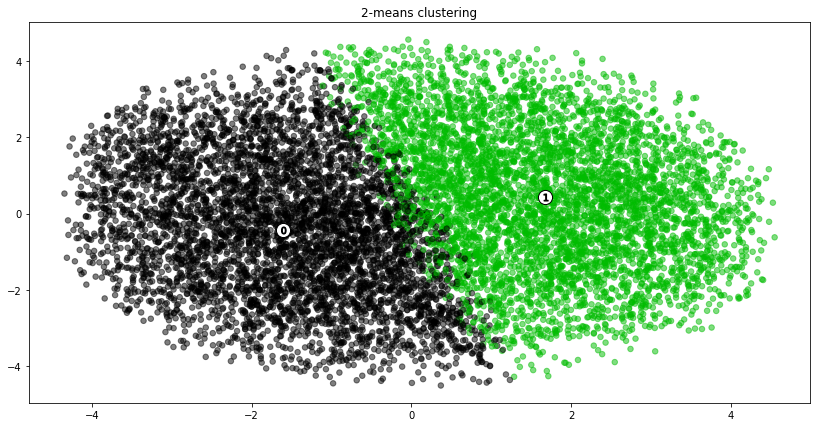

In [9]:
def kmeans_cluster_data(X, k=2, plot=True, fig=None, ax=None):
    """Takes in a dataset and clusters it for the n dimensions of the dataset.
    If plot is enabled, the dataset is then reduced using pca before being plotted in a 2 dimensional space
    Dimensions are kept for the clusterer
    
    returns labels"""
    clusterer = KMeans(n_clusters=k, random_state=SEED)
    labels = clusterer.fit_predict(X)
    
    if plot:
        if not (fig or ax):
            fig = plt.figure(figsize=(14, 7))
            ax = fig.add_subplot()
            
        elif fig:
            ax = fig.add_subplot()
            
        colors = cm.nipy_spectral(labels.astype(float) / k)
            
        ax.set_title(f"{k}-means clustering")
#         pca = PCA(n_components=2)
        pca = PCA(n_components=2)
        
        xp = pca.fit_transform(X)
        centroids = pca.transform(clusterer.cluster_centers_)
#         for i, c in enumerate(centroids):
#             ax.scatter(*xp[labels==i].T, label=f"label {i}", s=30, c=colors, alpha=0.5)
            
        ax.scatter(*xp.T, s=30, c=colors, alpha=0.5)
            
        ax.scatter(*centroids.T, marker='o', c="white", alpha=1, s=200, edgecolor='k')
        for i, c in enumerate(centroids):
            ax.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
            
#         ax.legend()
    return labels, clusterer

k4labels, _ = kmeans_cluster_data(X.to_numpy(), k=2)

In [6]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver="lbfgs", multi_class="auto", max_iter=5000)
lr.fit(X, k4labels)
"linear seperability for cluster:", lr.score(X, k4labels)

('linear seperability for cluster:', 0.9993)

For n_clusters = 2 The average silhouette_score is : 0.0881824804167372
For n_clusters = 3 The average silhouette_score is : 0.07344190215554072
For n_clusters = 4 The average silhouette_score is : 0.06649343494320313
For n_clusters = 5 The average silhouette_score is : 0.06454790571494126
For n_clusters = 6 The average silhouette_score is : 0.06308671467280616


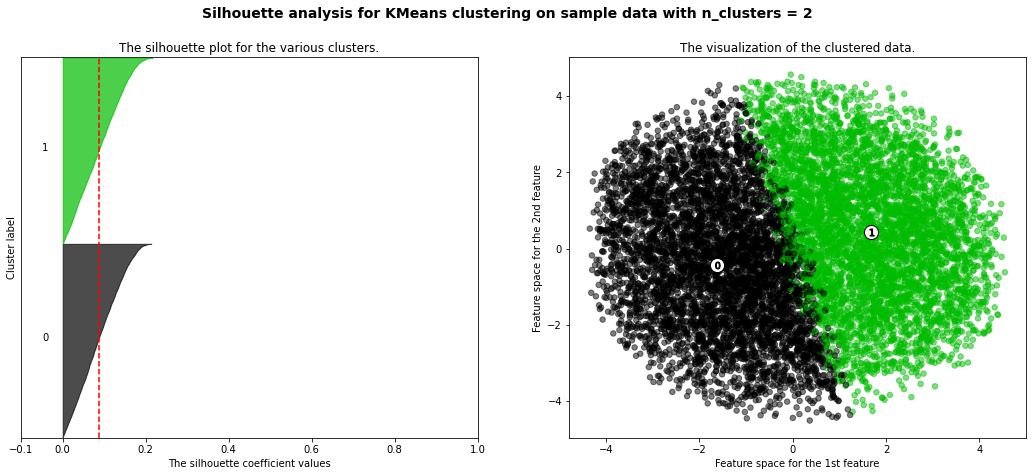

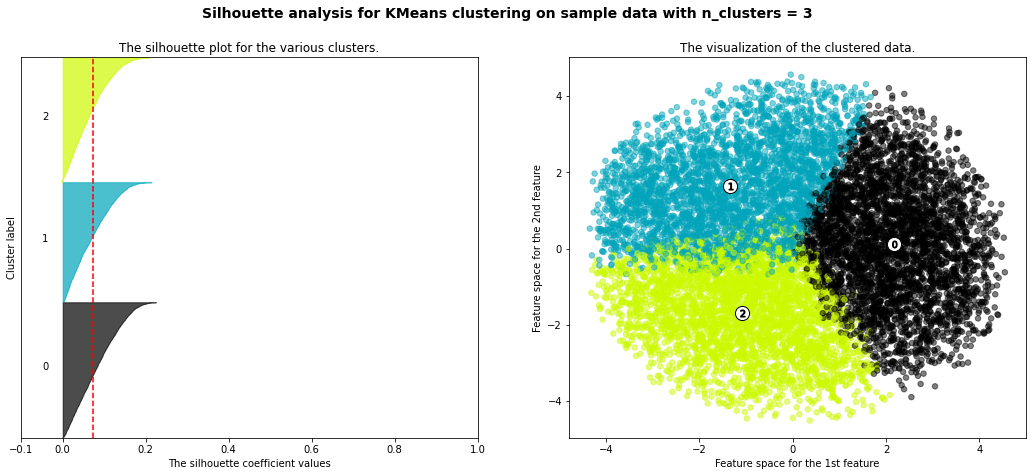

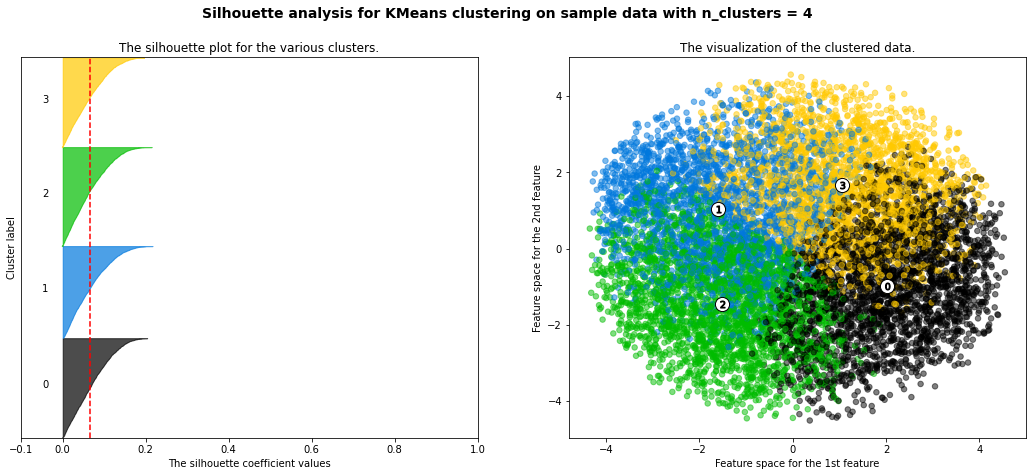

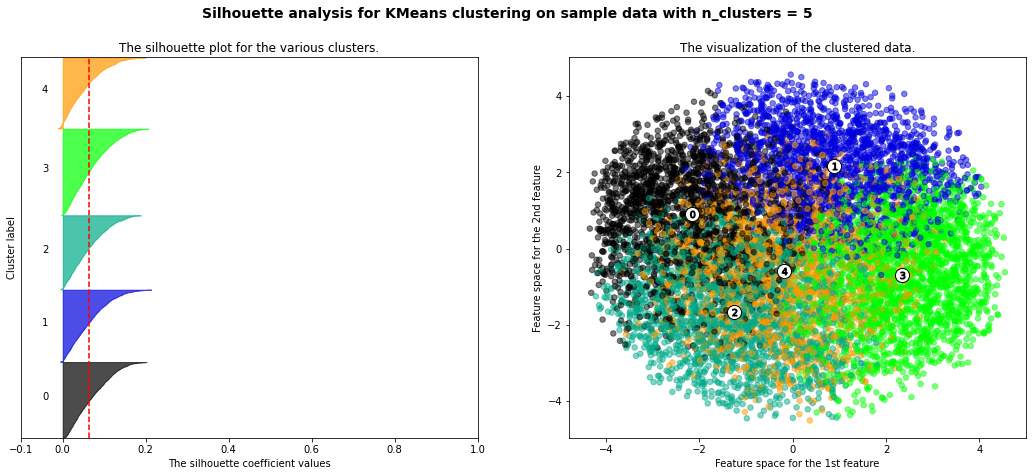

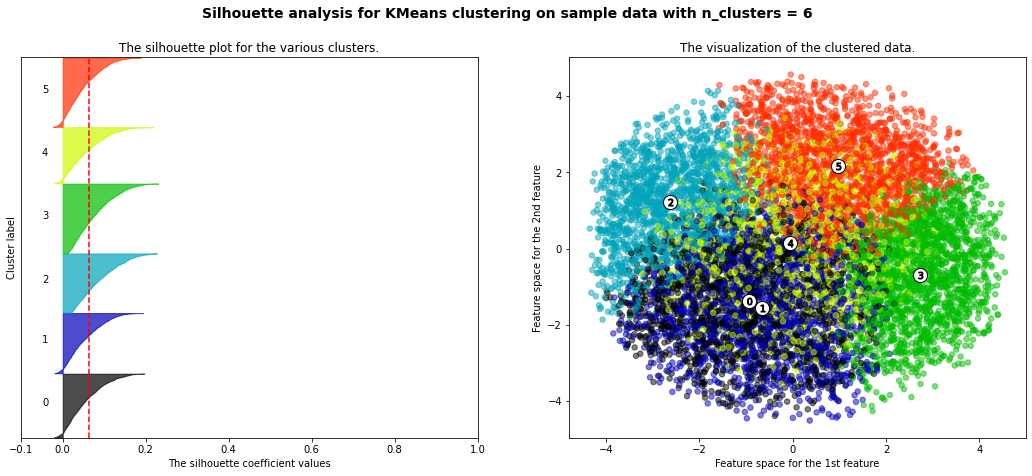

In [7]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    # clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    # cluster_labels = clusterer.fit_predict(X)
    
    cluster_labels, clusterer = kmeans_cluster_data(X, k=n_clusters, ax=ax2)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

For the clustering part:
* https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
* https://scikit-learn.org/stable/modules/biclustering.html

In [8]:
# do biclustering and grid-viz

(b) Try and determine whether some particular factors are
important for disease epidemiology and may require further investigations.
You need to be able to validate your findings either through a holdout-set methodology,
appropriately used statistical tests, or Bayesian model comparison.

* Shap values  

* Meaning of epidemiology? Do we predict disease or symptoms? Using which variables?

Measuring the effect of actions. We also observe the effects of two different therapeutic
interventions, one of which is placebo, and the other is an experimental drug. Try and measure
the effectiveness of the placebo versus the active treatment. Are there perhaps cases where the
active treatment is never effective, or should it always be recommended?
1

* Synthetic control 

## Part 2 - Improved Policy

## Part 3 - Adaptive experiment design